In [1]:
import numpy as np
import scipy.stats as stats

In [46]:
def bayesian_gaussian_mixture(nchain, data, hyper, ncomp):
    ## La je devrais mettre le modèle

    nobs = len(data)
    chain = np.zeros((nchain+1, ncomp, 3))##(omega, mu, sigma2)
    label_chain = np.zeros((nchain + 1, nobs))

    ## Create sensible starting values
    chain[0,:,0] = 1 / ncomp
    chain[0,:,1] = np.random.choice(data, size = ncomp, replace=False)
    chain[0,:,2] = 100

    ## Initialization of some quantities (once for all)
    pmf = np.zeros((nobs, ncomp))##will store the pmf of labelling variables
    comp_freq = np.zeros(ncomp)##will store probabilities of membership
    comp_sum = np.zeros(ncomp)##will store the sum within each component
    comp_ss = np.zeros(ncomp)##will store the sum of squares within each component
    
    for t in range(nchain):
        current = chain[t,:,:]
        label = label_chain[t,:]

        ## Update the labels
        for comp in range(ncomp):
            pmf[:,comp] = stats.norm.pdf(data, current[comp,1], np.sqrt(current[comp, 2])) * current[comp,0]
        
        ## Normalization to be a proper pmf
        normalization = np.sum(pmf, axis = 1)

        for i in range(nobs):
            label[i] = np.random.choice(ncomp, 1, p = pmf[i,:] / normalization[i])
    
        label = label.astype(int)
        ## Compute the frequencies for each component
        for comp in range(ncomp):
            comp_freq[comp] = np.sum(label == comp)

        ## Update the probabilities to belong to a component
        alpha_cond = hyper["proba"] + comp_freq
        current[:,0] = stats.dirichlet.rvs(alpha_cond, 1)

        ## Update the gaussian means
        for comp in range(ncomp):
            comp_sum[comp] = np.sum(data[label == comp])
        
        cond_var = 1 / (1 / hyper["mean"][1] + comp_freq / current[:,2])
        cond_mean = cond_var * (hyper["mean"][0] / hyper["mean"][1] +  comp_sum / current[:,2])
        current[:,1] = stats.norm.rvs(cond_mean, np.sqrt(cond_var), size = ncomp)

        ## Update the gaussian variance
        for comp in range(ncomp):
            comp_ss[comp] = np.sum((data[label == comp] - current[comp,1])**2)
        
        alpha_cond = hyper["var"][0] + 0.5 * comp_freq
        beta_cond = hyper["var"][1] + 0.5 * comp_ss
        current[:,2] = stats.invgamma.rvs(alpha_cond, scale = beta_cond, size = ncomp)

        ## Perform partial ordering for label switching issues
        order = np.argsort(current[:,1])
        current = current[order,:]
        label = order[label]

        ## Update the chain
        chain[t+1,:] = current
        label_chain[t+1,:] = label 
    
    return chain, label_chain

        


     
    

In [43]:
galaxies = np.array([9172, 9350,9483,9558,9775,10227,10406,16084,16170,18419,
18552,18600,18927,19052,19070,19330,19343,19349,19440,19473,
19529,19541,19547,19663,19846,19856,19863,19914,19918,19973,
19989,20166,20175,20179,20196,20215,20221,20415,20629,20795,
20821,20846,20875,20986,21137,21492,21701,21814,21921,21960,
22185,22209,22242,22249,22314,22374,22495,22746,22747,22888,
22914,23206,23241,23263,23484,23538,23542,23666,23706,23711,
24129,24285,24289,24366,24717,24990,25633,26690,26995,32065,
32789,34279]) / 1000

(array([0.03400082, 0.        , 0.00971452, 0.02914356, 0.15543231,
        0.11657423, 0.03400082, 0.00485726, 0.        , 0.01457178]),
 array([ 9.172 , 11.6827, 14.1934, 16.7041, 19.2148, 21.7255, 24.2362,
        26.7469, 29.2576, 31.7683, 34.279 ]),
 <BarContainer object of 10 artists>)

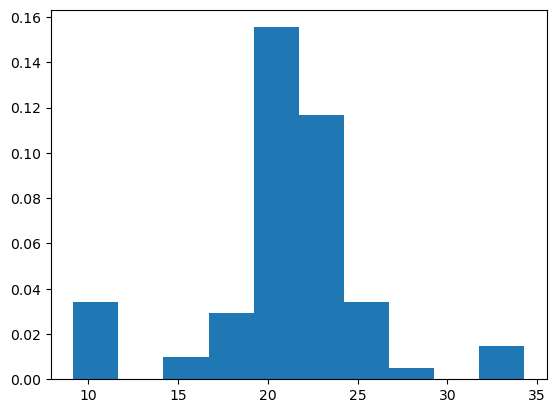

In [44]:
import matplotlib.pyplot as plt
plt.hist(galaxies, density=True)

In [81]:
nchain = 10**4
ncomp = 3
hyper = {
    "proba": np.ones(ncomp),
    "mean": [20, 100],
    "var": [0.1, 1]
}

chain, chain_label = bayesian_gaussian_mixture(nchain, galaxies, hyper, ncomp)

/var/folders/q7/ltq_388d7dbclpdk5n1w1vv00000gn/T/ipykernel_36456/1510411194.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label[i] = np.random.choice(ncomp, 1, p = pmf[i,:] / normalization[i])


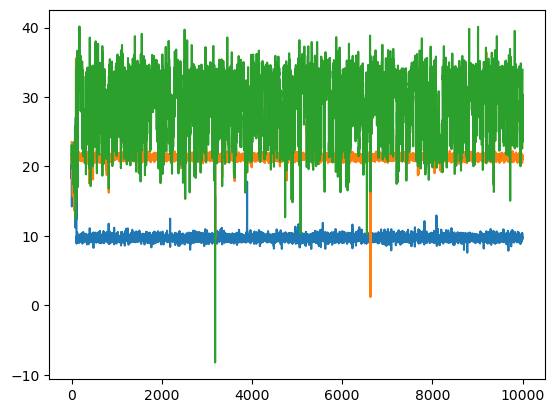

In [82]:
plt.plot(chain[:,:,1])
##plt.ylim(0, 1000)

(0.0, 100.0)

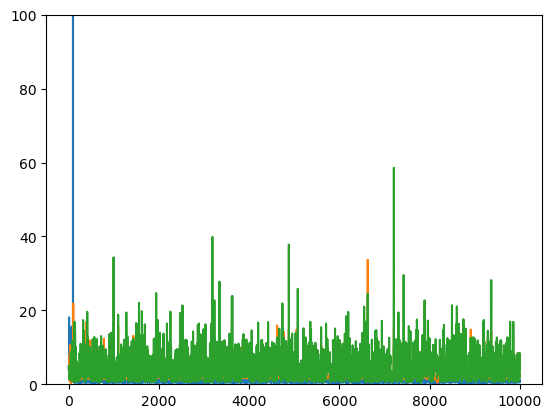

In [86]:
plt.plot(np.sqrt(chain[:,:,2]))
plt.ylim(0, 100)